In [20]:
!wget https://raw.githubusercontent.com/EdwardRaff/Inside-Deep-Learning/main/idlmam.py

--2023-05-17 18:51:43--  https://raw.githubusercontent.com/EdwardRaff/Inside-Deep-Learning/main/idlmam.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22064 (22K) [text/plain]
Saving to: ‘idlmam.py.1’

idlmam.py.1         100%[===================>]  21.55K  --.-KB/s    in 0s      

2023-05-17 18:51:43 (85.6 MB/s) - ‘idlmam.py.1’ saved [22064/22064]



In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_network, Flatten, weight_reset, View, set_seed

In [22]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

torch.backends.cudnn.deterministic=True
set_seed(42)

<ipython-input-22-b32d05908c7c>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [23]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [24]:
batch_size = 128
latent_d = 128
neurons = 512
out_shape = (-1, 28, 28)
num_epochs = 10

def fc_layer(in_neurons, out_neurons, leak=0.1):
  return nn.Sequential(
      nn.Linear(in_neurons, out_neurons),
      nn.LeakyReLU(leak),
      nn.LayerNorm(out_neurons)
  )

In [25]:
def simple_gan(latent_d, neurons, out_shape, sigmoidG=False, leak=0.2):
  G = nn.Sequential(
      fc_layer(latent_d, neurons, leak),
      fc_layer(neurons, neurons, leak),
      fc_layer(neurons, neurons, leak),
      nn.Linear(neurons, abs(np.prod(out_shape))),
      View(out_shape)
  )

  if sigmoidG:
    G = nn.Sequential(G, nn.Sigmoid())

  D = nn.Sequential(
      nn.Flatten(),
      fc_layer(abs(np.prod(out_shape)), neurons, leak),
      fc_layer(neurons, neurons, leak),
      fc_layer(neurons, neurons, leak),
      nn.Linear(neurons, 1)
  )

  return G, D


In [26]:

G, D = simple_gan(latent_d, neurons, out_shape, sigmoidG=True)

In [27]:
G.to(device)
D.to(device)

loss_func = nn.BCEWithLogitsLoss()
real_label = 1
fake_label = 0

optimizerD = torch.optim.AdamW(D.parameters(), lr=0.0001, betas=(0., 0.9))
optimizerG = torch.optim.AdamW(G.parameters(), lr=0.0001, betas=(0., 0.9))

In [28]:
train_data = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [29]:
G_losses, D_losses = [], []

for epoch in tqdm(range(num_epochs)):
  for x, y in tqdm(train_loader, leave=False):
    real_data = x.to(device)
    y_real = torch.full((batch_size, 1), real_label, dtype=torch.float32, device=device)
    y_fake = torch.full((batch_size, 1), fake_label, dtype=torch.float32, device=device)

    D.zero_grad()

    errD_real = loss_func(D(real_data), y_real)
    errD_real.backward()

    z = torch.randn(batch_size, latent_d, device=device)
    fake = G(z)

    errD_fake = loss_func(D(fake.detach()), y_fake)
    errD_fake.backward()

    errD = errD_real + errD_fake
    optimizerD.step()

    G.zero_grad()

    errG = loss_func(D(fake), y_real)
    errG.backward()
    optimizerG.step()

    G_losses.append(errG.item())
    D_losses.append(errD.item())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

In [30]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_d, device=device)
    fake_digits = G(noise) 
    scores = torch.sigmoid(D(fake_digits))
    
    fake_digits = fake_digits.cpu()
    scores = scores.cpu().numpy().flatten()

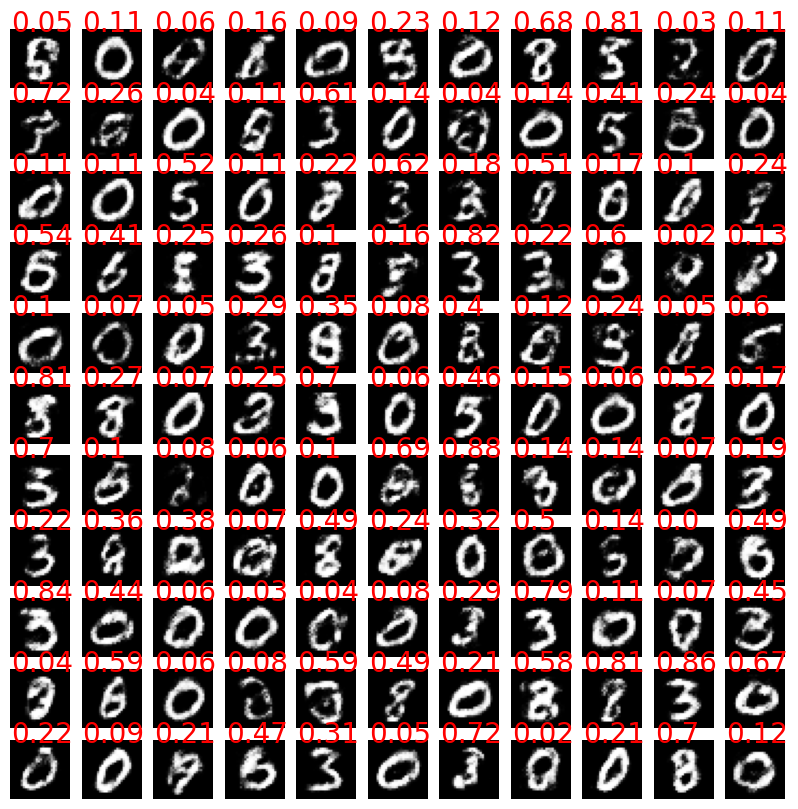

In [31]:
def plot_gen_imgs(fake_digits, scores=None):
    batch_size = fake_digits.size(0)
    #This code assumes we are working with black-and-white images
    fake_digits = fake_digits.reshape(-1, fake_digits.size(-1), fake_digits.size(-1))
    i_max = int(round(np.sqrt(batch_size)))
    j_max = int(np.floor(batch_size/float(i_max)))
    f, axarr = plt.subplots(i_max,j_max, figsize=(10,10))
    for i in range(i_max):
        for j in range(j_max):
            indx = i*j_max+j
            axarr[i,j].imshow(fake_digits[indx,:].numpy(), cmap='gray', vmin=0, vmax=1)
            axarr[i,j].set_axis_off()
            if scores is not None:
                axarr[i,j].text(0.0, 0.5, str(round(scores[indx],2)), dict(size=20, color='red'))
plot_gen_imgs(fake_digits, scores)

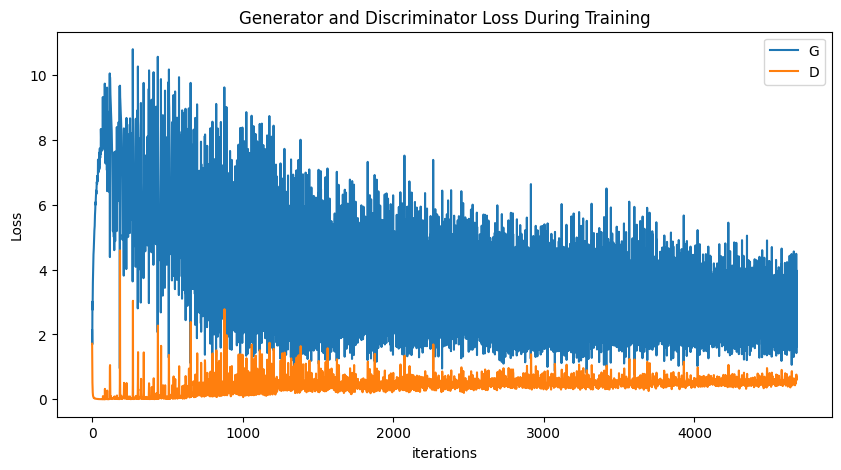

In [32]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()